# 🌍 Hyperspectral Endmember Extraction and Abundance Mapping using N-FINDR

This notebook demonstrates **endmember extraction** using the **N-FINDR algorithm** and subsequent **abundance estimation** using **Non-Negative Least Squares (NNLS)**.  

We will:
1. Load a hyperspectral cube (ENVI format, BSQ interleave).
2. Apply N-FINDR to extract endmembers.
3. Plot and save the extracted endmember spectra.
4. Estimate abundance maps using NNLS.
5. Save the results both as **ENVI rasters** and **PNG visualizations**.

Data Used:
1. Dataset was downloaded from https://opendata.wyvern.space/
2. Area of Intrest : Suez Canal - 2024/08/08
3. ToA Radiance data was converted to ToA Reflectance using ENVI QUAC.
4. Dataset was subsetted to 800*400 and convert to BSQ format.

**Note: Use Scipy version 1.11.4 and conda for maximum performance and error free results.**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from spectral import open_image
from spectral.io.envi import save_image
from scipy.optimize import nnls
import random
from tqdm import tqdm

## ⚙️ User Parameters

Define the input hyperspectral cube and processing parameters here.

In [2]:
# Path to ENVI .hdr file (corresponding .img/.bsq must exist)
hdr_path = "subset_wyvern.hdr"

# Number of endmembers to extract
n_endmembers = 5

# Subsample size for N-FINDR (None = use all pixels)
sample_size = None

# Maximum iterations for N-FINDR refinement
max_iter = 5

# Output directory
output_dir = "nfindr_output"
os.makedirs(output_dir, exist_ok=True)

## 📥 Reading the Hyperspectral Cube

We use the `spectral` library to read an ENVI BSQ cube.  
The cube is reshaped into a 2D array where each row corresponds to a pixel spectrum.

In [3]:
def read_envi_cube(hdr_path):
    """Open ENVI cube and return array + metadata."""
    img = open_image(hdr_path)
    arr = img.load()
    return arr, img.metadata


def reshape_cube_to_2d(cube):
    """Reshape cube from (rows, cols, bands) → (pixels, bands)."""
    rows, cols, bands = cube.shape
    X = cube.reshape((-1, bands)).astype(np.float64)
    return X, rows, cols, bands


# Load cube
print("Reading hyperspectral cube...")
cube, meta = read_envi_cube(hdr_path)
X, rows, cols, bands = reshape_cube_to_2d(cube)
print(f"Cube dimensions: {rows} x {cols}, Bands = {bands}")

Reading hyperspectral cube...
Cube dimensions: 2365 x 1254, Bands = 23


## 📐 N-FINDR Algorithm

N-FINDR extracts endmembers by maximizing the simplex volume spanned by candidate spectra.  
We start with greedy initialization, then refine via iterative replacements.

In [4]:
def compute_simplex_volume(matrix):
    """Compute volume of simplex formed by given endmembers."""
    p = matrix.shape[0]
    A = (matrix[1:] - matrix[0]).T
    M = A.T @ A
    sign, logdet = np.linalg.slogdet(M)
    if sign <= 0:
        return 0.0
    return 0.5 * logdet


def nfindr(X, p, sample_idx=None, max_iter=5, verbose=True):
    """Perform N-FINDR to extract endmembers from spectral data."""
    if sample_idx is None:
        sample_idx = np.arange(X.shape[0])
    else:
        sample_idx = np.asarray(sample_idx)

    Xs = X[sample_idx]
    n = Xs.shape[0]

    # --- Greedy initialization ---
    em_idx_local = [random.randint(0, n - 1)]
    for k in range(1, p):
        chosen_vecs = Xs[em_idx_local]
        dists = np.min(np.linalg.norm(Xs[:, None, :] - chosen_vecs[None, :, :], axis=2), axis=1)
        next_idx = np.argmax(dists)
        em_idx_local.append(next_idx)

    em_idx = sample_idx[np.array(em_idx_local)]
    if verbose:
        print(f"Initial endmember indices: {em_idx}")

    # --- Iterative replacement ---
    for it in range(max_iter):
        replaced = False
        if verbose:
            print(f"N-FINDR iteration {it+1}/{max_iter} ...")
        current_EM = X[em_idx]
        base_vol = compute_simplex_volume(current_EM)
        for r in range(p):
            best_idx_for_r = em_idx[r]
            best_vol = base_vol
            for cand_local_idx in range(0, Xs.shape[0], max(1, Xs.shape[0] // 2000)):
                cand_global = sample_idx[cand_local_idx]
                if cand_global in em_idx:
                    continue
                trial_em = current_EM.copy()
                trial_em[r] = X[cand_global]
                vol = compute_simplex_volume(trial_em)
                if vol > best_vol:
                    best_vol = vol
                    best_idx_for_r = cand_global
            if best_idx_for_r != em_idx[r]:
                em_idx[r] = best_idx_for_r
                current_EM = X[em_idx]
                base_vol = best_vol
                replaced = True
        if not replaced:
            if verbose:
                print("No replacements increased volume — stopping early.")
            break

    return em_idx

### Run N-FINDR

In [5]:
# Subsampling (optional)
if sample_size is not None and sample_size < X.shape[0]:
    sample_idx = np.random.choice(X.shape[0], size=sample_size, replace=False)
else:
    sample_idx = None

# Run N-FINDR
em_indices = nfindr(X, n_endmembers, sample_idx=sample_idx, max_iter=max_iter, verbose=True)
endmembers = X[em_indices]

# Save indices and spectra
np.save(os.path.join(output_dir, "endmember_spectra.npy"), endmembers)

print("Extracted endmembers saved.")

Initial endmember indices: [2708128 2859238  113978 1045639  898153]
N-FINDR iteration 1/5 ...
N-FINDR iteration 2/5 ...
N-FINDR iteration 3/5 ...
No replacements increased volume — stopping early.
Extracted endmembers saved.


## 📊 Plot Endmember Spectra

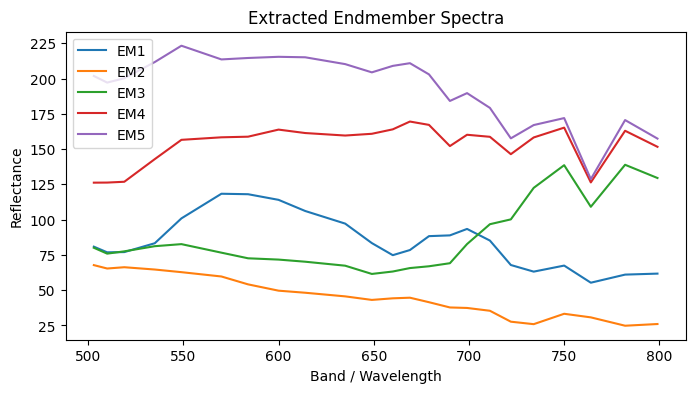

In [6]:
def plot_endmember_spectra(endmembers, wavelengths=None, save_path=None):
    """Plot and optionally save extracted endmember spectra."""
    p, bands = endmembers.shape
    plt.figure(figsize=(8, 4))
    for i in range(p):
        plt.plot(wavelengths if wavelengths is not None else np.arange(bands),
                 endmembers[i], label=f'EM{i+1}')
    plt.xlabel("Band / Wavelength")
    plt.ylabel("Reflectance")
    plt.legend()
    plt.title("Extracted Endmember Spectra")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=200)
    plt.show()


# Extract wavelengths if available
wavelengths = None
if 'wavelength' in meta:
    try:
        wavelengths = np.array([float(w) for w in meta['wavelength']])
    except Exception:
        wavelengths = None

# Plot
plot_endmember_spectra(endmembers, wavelengths=wavelengths,
                       save_path=os.path.join(output_dir, "endmember_spectra.png"))

## 💾 Save Endmembers as ENVI Raster

In [7]:
em_cube = endmembers.reshape((n_endmembers, 1, bands))
em_meta = {
    'description': 'N-FINDR extracted endmembers',
    'lines': n_endmembers,
    'samples': 1,
    'bands': bands,
    'interleave': 'bsq',
    'wavelength_units': meta.get('wavelength units', 'Unknown'),
}
if 'wavelength' in meta:
    em_meta['wavelength'] = meta['wavelength']

em_save_path = os.path.join(output_dir, 'nfindr_endmembers.hdr')
save_image(em_save_path, em_cube, metadata=em_meta, dtype=np.float32, force=True)
print("Endmembers saved as ENVI raster.")

Endmembers saved as ENVI raster.


## 🔎 Abundance Estimation using NNLS
We solve a **non-negative least squares problem** for each pixel spectrum with respect to the extracted endmembers.

In [8]:
def estimate_abundances_nnls(X, endmembers):
    """Estimate abundance fractions using NNLS."""
    p, bands = endmembers.shape
    n_pixels = X.shape[0]
    A = np.zeros((n_pixels, p), dtype=np.float32)
    E = endmembers.T
    for i in tqdm(range(n_pixels), desc="Estimating abundances"):
        x = X[i]
        a, rnorm = nnls(E, x)
        s = a.sum()
        if s > 0:
            a = a / s
        A[i, :] = a
    return A


# Run abundance estimation
A = estimate_abundances_nnls(X, endmembers)
np.save(os.path.join(output_dir, "abundance_maps.npy"), A)

Estimating abundances: 100%|██████████████████████████████████████████████| 2965710/2965710 [01:22<00:00, 35976.88it/s]


## 💾 Save Abundance Maps (ENVI + PNG)

In [9]:
def save_abundance_maps_envi_stacked(A, rows, cols, n_endmembers, meta, output_dir):
    """
    Save all abundance maps into a single stacked ENVI file (rows x cols x n_endmembers).
    """
    # Reshape A into cube
    abundance_cube = A.reshape((rows, cols, n_endmembers))

    # Metadata update
    map_meta = meta.copy()
    map_meta.update({
        'description': 'Stacked abundance maps from N-FINDR',
        'bands': n_endmembers,
        'interleave': 'bsq'
    })

    outp_hdr = os.path.join(output_dir, "abundance_maps_stacked.hdr")
    save_image(outp_hdr, abundance_cube, metadata=map_meta, dtype=np.float32, force=True)
    print(f"✅ Stacked abundance maps saved at: {outp_hdr}")


def save_abundance_maps_png(A, rows, cols, n_endmembers, output_dir, cmap='viridis'):
    """Save abundance maps as PNGs."""
    for k in range(n_endmembers):
        img = A[:, k].reshape((rows, cols))
        plt.figure(figsize=(6, 5))
        plt.imshow(img, cmap=cmap)
        plt.title(f"Abundance Map - EM{k+1}")
        plt.colorbar(label='abundance')
        outp = os.path.join(output_dir, f"abundance_EM{k+1}.png")
        plt.savefig(outp, bbox_inches='tight', dpi=200)
        plt.close()


# Save maps
save_abundance_maps_envi_stacked(A, rows, cols, n_endmembers, meta, output_dir)
save_abundance_maps_png(A, rows, cols, n_endmembers, output_dir)

print(f"✅ Processing complete. All outputs saved in: {output_dir}")

✅ Stacked abundance maps saved at: nfindr_output\abundance_maps_stacked.hdr
✅ Processing complete. All outputs saved in: nfindr_output


## 🎨 Visualize Abundance Maps with Matplotlib

Here we plot the abundance maps of all extracted endmembers directly inside the notebook.

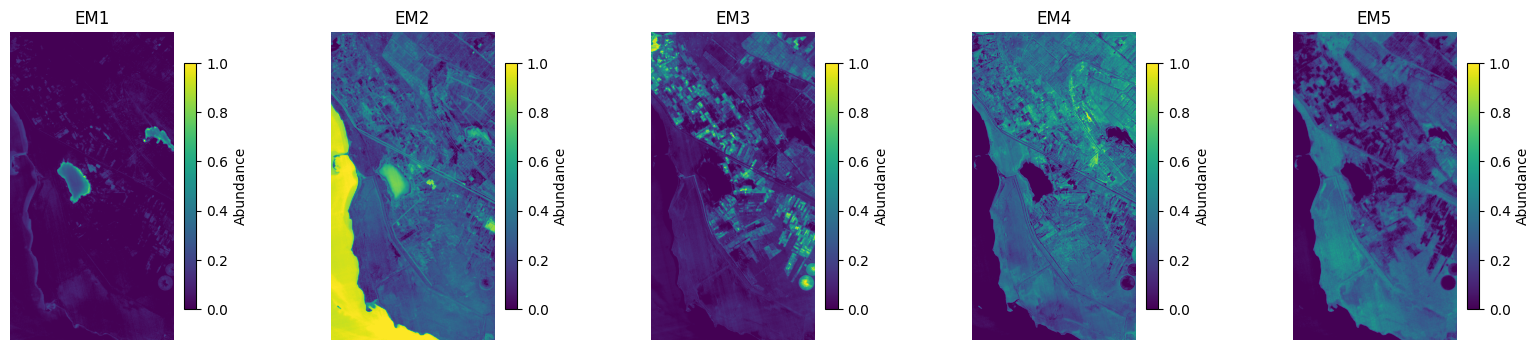

In [10]:
def plot_abundance_maps(A, rows, cols, n_endmembers, cmap='viridis'):
    """Display abundance maps using matplotlib subplots."""
    fig, axes = plt.subplots(1, n_endmembers, figsize=(4*n_endmembers, 4))
    if n_endmembers == 1:
        axes = [axes]  # ensure iterable
    
    for k in range(n_endmembers):
        img = A[:, k].reshape((rows, cols))
        ax = axes[k]
        im = ax.imshow(img, cmap=cmap)
        ax.set_title(f"EM{k+1}")
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Abundance")

    plt.show()


# Plot abundance maps in notebook
plot_abundance_maps(A, rows, cols, n_endmembers)

In [13]:
def save_endmembers_ascii(endmembers, wavelengths, output_dir):
    """
    Save extracted endmember spectra as ASCII text.
    Each row = one endmember spectrum.
    If wavelengths are available, first column = wavelength.
    """
    outp_txt = os.path.join(output_dir, "endmember_spectra.txt")

    if wavelengths is not None:
        data_to_save = np.column_stack((wavelengths, endmembers.T))
        header = "Wavelength\t" + "\t".join([f"EM{i+1}" for i in range(endmembers.shape[0])])
    else:
        data_to_save = endmembers
        header = "\t".join([f"EM{i+1}" for i in range(endmembers.shape[0])])

    np.savetxt(outp_txt, data_to_save, fmt="%.6f", delimiter="\t", header=header)
    print(f"✅ Endmember spectra saved as ASCII at: {outp_txt}")
    
save_endmembers_ascii(endmembers, wavelengths, output_dir)

NameError: name 'outpur_dir' is not defined